In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")
time = df["time"]
df = df.drop(columns=["time"])

X = df.drop(columns=["Y1", "Y2"])
y1 = df["Y1"]
y2 = df["Y2"]
corrs_y1 = X.corrwith(y1).abs()
corrs_y2 = X.corrwith(y2).abs()

X1_features = X.loc[:, corrs_y1 > corrs_y2]  
X2_features = X.loc[:, corrs_y2 >= corrs_y1] 
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_features, y1, test_size=0.4, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_features, y2, test_size=0.4, random_state=42)


In [ ]:
xgb_y1 = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)
xgb_y2 = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)

xgb_y1.fit(X1_train, y1_train)
xgb_y2.fit(X2_train, y2_train)

y1_pred_base = xgb_y1.predict(X1_test)
y2_pred_base = xgb_y2.predict(X2_test)

print("XGB R2 Y1:", r2_score(y1_test, y1_pred_base))
print("XGB R2 Y2:", r2_score(y2_test, y2_pred_base))

rolling_vol = pd.DataFrame({
    "vol_y1": y1.rolling(window).std().fillna(0),
    "vol_y2": y2.rolling(window).std().fillna(0)
})
hmm = GaussianHMM(n_components=2, covariance_type="full", n_iter=200, random_state=42)
hmm.fit(rolling_vol)
states = hmm.predict(rolling_vol) 
df["regime"] = states
regime_vols = rolling_vol.groupby(states).mean().mean(axis=1)
high_vol_regime = regime_vols.idxmax()


high_vol_idx = df["regime"] == high_vol_regime
X_cross_y1 = X2_features[high_vol_idx]
X_cross_y2 = X1_features[high_vol_idx]
y1_high = y1[high_vol_idx]
y2_high = y2[high_vol_idx]
cross_y1 = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
cross_y2 = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)

cross_y1.fit(X_cross_y1, y1_high)
cross_y2.fit(X_cross_y2, y2_high)
y1_pred_final = y1_pred_base.copy()
y2_pred_final = y2_pred_base.copy()
high_vol_test_idx = df.iloc[X1_test.index]["regime"] == high_vol_regime
y1_pred_final[high_vol_test_idx] += cross_y1.predict(X2_test[high_vol_test_idx])
y2_pred_final[high_vol_test_idx] += cross_y2.predict(X1_test[high_vol_test_idx])
print("Final R2 Y1:", r2_score(y1_test, y1_pred_final))
print("Final R2 Y2:", r2_score(y2_test, y2_pred_final))

Base XGB R2 Y1: 0.753994954616119
Base XGB R2 Y2: 0.7019594176280919
Final R2 Y1: 0.7455180878857375
Final R2 Y2: 0.51107676561069


C:\Users\Sahil\AppData\Local\Temp\ipykernel_15652\32277926.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(CSV_PATH, parse_dates=["time"], infer_datetime_format=True)
C:\Users\Sahil\AppData\Local\Temp\ipykernel_15652\32277926.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(CSV_PATH, parse_dates=["time"], infer_datetime_format=True)
C:\Users\Sahil\AppData\Local\Temp\ipykernel_15652\32277926.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["time"

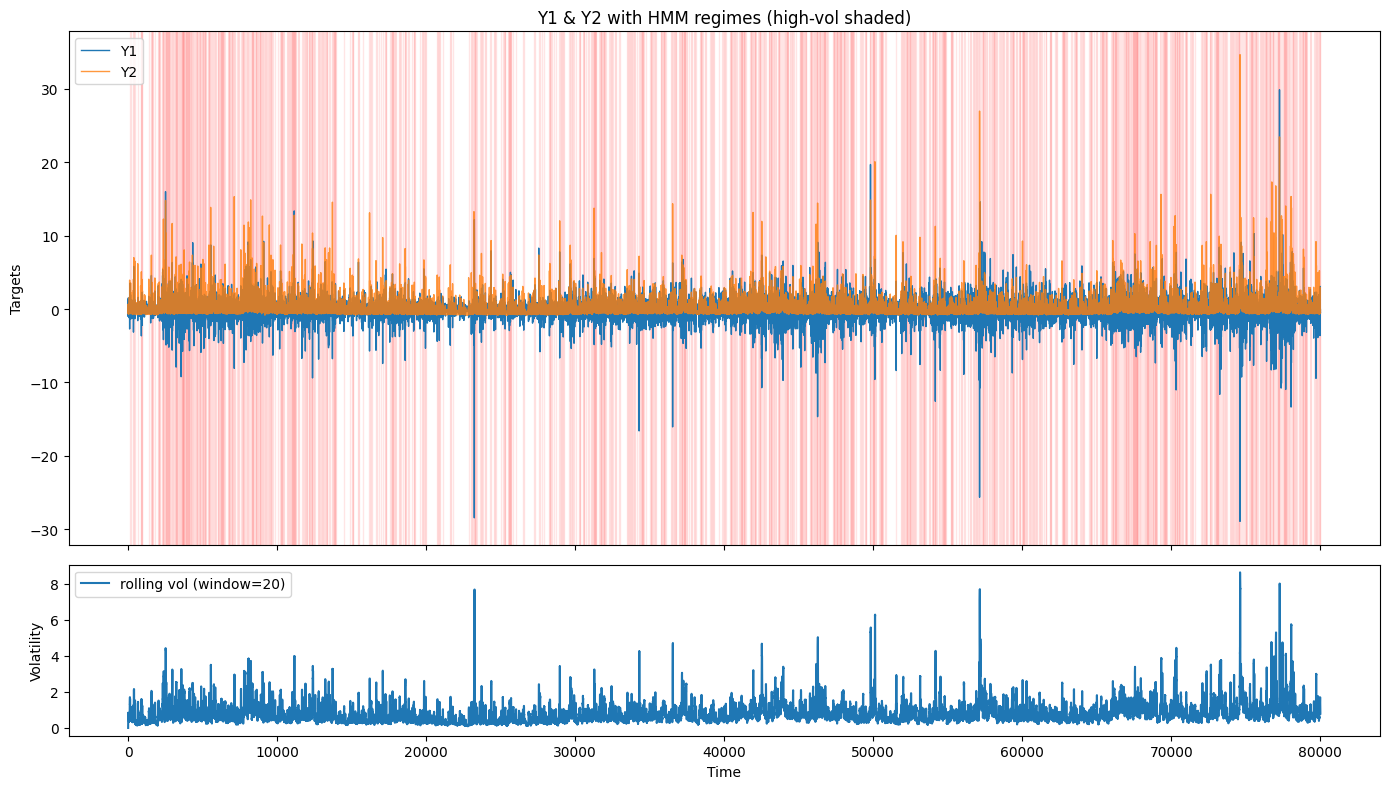

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

CSV_PATH = "train.csv"
VOL_WINDOW = 20       
HMM_COMPONENTS = 2         
HMM_COV = "diag"
RANDOM_STATE = 42

df = pd.read_csv(CSV_PATH, parse_dates=["time"], infer_datetime_format=True)


df["time"] = pd.to_datetime(df["time"])
if "time" not in df.columns:
    df["time"] = pd.RangeIndex(start=0, stop=len(df), step=1)

y1 = df["Y1"]
y2 = df["Y2"]
returns = pd.concat([y1, y2], axis=1).diff().fillna(0)
rolling_vol = returns.rolling(window=VOL_WINDOW, min_periods=1).std().fillna(0)
vol_feature = rolling_vol.mean(axis=1).values.reshape(-1, 1)
scaler = StandardScaler()
vol_std = scaler.fit_transform(vol_feature)

hmm = GaussianHMM(n_components=HMM_COMPONENTS, covariance_type=HMM_COV,
                  n_iter=200, random_state=RANDOM_STATE)
hmm.fit(vol_std)   
hidden_states = hmm.predict(vol_std)

state_means = [vol_feature[hidden_states == s].mean() for s in range(HMM_COMPONENTS)]
order = np.argsort(state_means)  # ascending: low -> high
remapped = np.array([np.where(order == s)[0][0] for s in hidden_states])
df["regime"] = remapped           # 0 low vol, 1 high vol (if 2 components)




times = df["time"]
states = df["regime"].values
segments = []
start_idx = 0
curr_state = states[0]
for i in range(1, len(states)):
    if states[i] != curr_state:
        segments.append((start_idx, i-1, curr_state))
        start_idx = i
        curr_state = states[i]

segments.append((start_idx, len(states)-1, curr_state))




fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                                     gridspec_kw={"height_ratios": [3, 1]})

ax_top.plot(times, y1, label="Y1", linewidth=1)
ax_top.plot(times, y2, label="Y2", linewidth=1, alpha=0.8)
ax_top.set_title("Y1 & Y2 with HMM regimes (high-vol shaded)")
ax_top.set_ylabel("Targets")
ax_top.legend(loc="upper left")

for s, e, st in segments:
    if st == 1: 
        t0 = times.iloc[s]
        t1 = times.iloc[e]
        ax_top.axvspan(t0, t1, color="red", alpha=0.10)

ax_bot.plot(times, vol_feature, label=f"rolling vol (window={VOL_WINDOW})")
ax_bot.set_ylabel("Volatility")
ax_bot.set_xlabel("Time")
ax_bot.legend(loc="upper left")

plt.tight_layout()
plt.show()
